# Homework 1

In [1]:
import pandas as pd
import random
random.seed(9823)
import math

import seaborn as sns
import matplotlib.pyplot as plt

## Load the data

The dataset consists of random 17 documents from several topics. It has 2 columns: title, text. 

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/matteocirca/data-mining-course-kth-2023/main/hw1/data/applications_of_DM.csv', sep=',')
df

,title,text
0,Anomaly Detection at Multiple Scales,"Anomaly Detection at Multiple Scales, or ADAMS..."
1,Behavioral analytics,Behaviorism is a systematic approach to unders...
2,Business analytics,Business analysis is a professional discipline...
3,CORE (research service),CORE (Connecting Repositories) is a service pr...
4,Daisy Intelligence,Daisy Intelligence is a Canadian Artificial In...
5,Data Applied,Data Applied is a software vendor headquartere...
6,Data mining in agriculture,Data mining in agriculture is a recent researc...
7,Data thinking,"Data thinking is a buzzword for the generic ""m..."
8,Document processing,Document processing is a field of research and...
9,Equifax Workforce Solutions,"Equifax Workforce Solutions, formerly known as..."


## Classes

Disclaimer: we are generating different length vectors for each document after shingling. Let us say we have doc1 with 200 length vector, and doc2 with 300 length vector. Therefore, when we compute the MinHashing, we will run the same hashing function 200 times for doc1 and 300 times for doc2. Nevertheless, we will have the same number of hash values for each document after MinHashing, but there is an unbalance when computing the single values for each hash function. We think this does not have a big impact on the results, but we wanted to mention it.

Disclaimer: even if we set the seed for the random library, the modulus num_shingles changes the results slightly for different datasets.

In [3]:
class Shingling:
    def __init__(self, k):
        self.k = k  # The length of the shingle
        self.N = 2 ** 32 - 1 # The modulus for hashing. Large number picked to avoid collisions

    """
    This function processes a given text document and creates a set of "shingles". 
    A shingle is a contiguous substring of the document of length 'k'. Each shingle 
    is hashed to a numerical value, and these hashed values are stored in a set. 

    Parameters:
    - self: The instance of the class containing the method. Assumes attributes 'k' 
            (shingle length) and 'N' (modulus for hashing) are set.
    - document (str): The text document to be shingled.

    Returns:
    - set: A set of integers, each being the hashed value of a shingle from the 
        document.
    """
    def shingle_document(self, document):
        shingles = set()
        for i in range(len(document) - self.k + 1):
            shingle = document[i:i + self.k]
            hash_val = hash(shingle) % self.N
            shingles.add(hash_val)
        return shingles

class CompareSets:
    """
    This function computes the Jaccard-similarity of two sets.
    Paramaters:
    - set1 (set): The first set to be compared.
    - set2 (set): The second set to be compared.
    Returns:
    - float: The Jaccard similarity of the two sets calculated as
        |set1 intersection set2| / |set1 union set2|.
    """
    def jaccard_similarity(set1, set2):
        intersection = set1.intersection(set2)
        union = set1.union(set2)
        return len(intersection) / len(union)

class MinHashing:
    def __init__(self, k, num_shingles):
        self.k = k  # The length of the signature
        self.num_shingles = num_shingles # c from the lecture. num_shingles has been chosen as it is a large number 
                                         # that makes sense for this application. Since we are hashing the shingles 
                                         # of a document in a k length signature, it is not possible to have conflict 
                                         # in the total number of shingles (our c)
        self.coefficients = [(random.randint(0, num_shingles), random.randint(0, num_shingles)) for _ in range(k)]

    """ 
    This function computes the minhash signature of a set of shingles.
    Parameters:
    - self: The instance of the class containing the method. Assumes attribute 
            'coefficients', 'num_shingles' and k are set.
    - shingles (set): A set of shingles (set of integers).
    Returns:
    - list: The minhash signature of the set of shingles (list of integers).
    """
    def minhash(self, shingles):
        signature = []
        for a, b in self.coefficients:
            min_hash = min([(a * shingle + b) % self.num_shingles for shingle in shingles]) # h(x) = (ax + b) % c
            signature.append(min_hash)
        return signature

class CompareSignatures:
    """
    Same as before but for lists instead of sets.
    """
    def jaccard_similarity(sig1, sig2):
        intersection = 0
        for i in range(len(sig1)):
            if sig1[i] == sig2[i]:
                intersection += 1
        return intersection / len(sig1)

class LSH:
    def __init__(self, b, r, num_shingles):
        self.b = b # Number of bands
        self.r = r # Number of rows per band
        self.num_shingles = num_shingles # c from the lecture. num_shingles has been chosen as it is a large number (same as before)
        self.coefficients = (random.randint(0, num_shingles), random.randint(0, num_shingles)) # same hash function for all of the bands
        self.buckets = [{} for _ in range(b)] # b buckets, one for each band

    """
    This function hash the signature of a document into b buckets.
    It takes parameters:
    - self: The instance of the class.
    - signature: The signature of the document to be hashed.
    Returns:
    - list: A list of b integers, each in the range [0, num_buckets).
    """
    def hash(self, signature):
        hashes = []
        for i in range(self.b):
            a = self.coefficients[0]
            b = self.coefficients[1]
            hash_val = min([(a * signature[i * self.r + j] + b) % self.num_shingles for j in range(self.r)]) # h(x) = (ax + b) % c. We hash r rows at a time (1 band)
            hashes.append(hash_val)
        return hashes

    """
    This function takes parameters:
    - self: The instance of the class.
    - hash1: The hash value of the signature of document 1.
    - hash2: The hash value of the signature of document 2.
    Returns:
    - float: The estimated Jaccard similarity of the two documents. Computed as
        the fraction of bands for which the documents are candidates.
    """
    def query(self, hash1, hash2):
        candidate_pairs = 0
        for i in range(self.b):
            if hash1[i] == hash2[i]:
                candidate_pairs += 1
        return candidate_pairs/self.b


### Dummy example

Let us now test the Shingling with a dummy example. We took $K=3$ because of the shortness of the documents in the example. With increasing k-s the less similar the documents are going to be, since we are anlyzing larger chunks and it is more rare to have similar chunks of that size, while it is easier to have 1-grams, 2-grams in common.

In [4]:
doc1 = "hello world today is a good day to die"
doc2 = "hello world today is a good day to live"
doc3 = "this document is very different from the other two documents"

shingling = Shingling(k=3)
shingles1 = shingling.shingle_document(doc1)
shingles2 = shingling.shingle_document(doc2)
shingles3 = shingling.shingle_document(doc3)

print("Jaccard similarity between doc1 and doc2 is: ", CompareSets.jaccard_similarity(shingles1, shingles2))
print("Jaccard similarity between doc1 and doc3 is: ", CompareSets.jaccard_similarity(shingles1, shingles3))
print("Jaccard similarity between doc2 and doc3 is: ", CompareSets.jaccard_similarity(shingles2, shingles3))

Jaccard similarity between doc1 and doc2 is:  0.8108108108108109
Jaccard similarity between doc1 and doc3 is:  0.05263157894736842
Jaccard similarity between doc2 and doc3 is:  0.02531645569620253


Let us now try with $k=1$. We expect to have higher similarities even if the documents d1-d3 and d2-d3 are completely different.

In [5]:
doc1 = "hello world today is a good day to die"
doc2 = "hello world today is a good day to live"
doc3 = "this document is very different from the other two documents"

shingling = Shingling(k=1)
shingles1 = shingling.shingle_document(doc1)
shingles2 = shingling.shingle_document(doc2)
shingles3 = shingling.shingle_document(doc3)

print("Jaccard similarity between doc1 and doc2 is: ", CompareSets.jaccard_similarity(shingles1, shingles2))
print("Jaccard similarity between doc1 and doc3 is: ", CompareSets.jaccard_similarity(shingles1, shingles3))
print("Jaccard similarity between doc2 and doc3 is: ", CompareSets.jaccard_similarity(shingles2, shingles3))

Jaccard similarity between doc1 and doc2 is:  0.9333333333333333
Jaccard similarity between doc1 and doc3 is:  0.55
Jaccard similarity between doc2 and doc3 is:  0.6


Let us now test the MinHashing class and methods on the same dummy example presented before.

In [6]:
# Get the shingles for each document
shingling = Shingling(k=3)
documents = [doc1, doc2, doc3]

shingles = [shingling.shingle_document(document) for document in documents] # Get the total number of shingles
num_shingles = len(set().union(*shingles)) # This is the c parameter of the hash functions

print("Total number of shingles across all documents", num_shingles)

Total number of shingles across all documents 80


Now, we need to choose k wisely, as random guesses would not end up in good results. $K=1$ is too small and the expected error is too high. Larger k-s are better, as we can potentially reach the original number of shingles (rows of the shingles x documents matrix) and minimize the error. However, the computational cost is too high. We need to find a trade-off between the two. We can try with $K=20\%$ of the document with the highest number of shingles (length of the shingles x documents matrix).

In [7]:
len(shingles3) # The document with the longest shingle set

17

In [8]:
int(len(shingles3) / 100 * 20) # The number of hash functions we need to use

3

In [9]:
min_hashing = MinHashing(k=3, num_shingles=num_shingles)

minhashes1 = min_hashing.minhash(shingles[0])
minhashes2 = min_hashing.minhash(shingles[1])
minhashes3 = min_hashing.minhash(shingles[2])

print("Jaccard similarity between doc1 and doc2 is: ", CompareSignatures.jaccard_similarity(minhashes1, minhashes2))
print("Jaccard similarity between doc1 and doc3 is: ", CompareSignatures.jaccard_similarity(minhashes1, minhashes3))
print("Jaccard similarity between doc2 and doc3 is: ", CompareSignatures.jaccard_similarity(minhashes2, minhashes3))

Jaccard similarity between doc1 and doc2 is:  1.0
Jaccard similarity between doc1 and doc3 is:  0.6666666666666666
Jaccard similarity between doc2 and doc3 is:  0.6666666666666666


### Real data

Let us now run all the classes and methods for the real data.

#### Shingling

In [10]:
# Compute the shingles
shingling = Shingling(k=9) # k=9,10 was suggested on the slides (good for long documents)

shingles_dict = {}

for i, row in df.iterrows():
    shingles_dict[i] = shingling.shingle_document(row['text'])

In [11]:
# Comput Jaccard Similarity with CompareSets
jaccard_similarities = pd.DataFrame(columns=[i for i in range(len(shingles_dict))], index=[i for i in range(len(shingles_dict))])

for i in shingles_dict.keys():
    for j in shingles_dict.keys():
        jaccard_similarities[i][j] = CompareSets.jaccard_similarity(shingles_dict[i], shingles_dict[j])

jaccard_similarities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.0,0.002041,0.00414,0.006081,0.003115,0.008609,0.006334,0.006459,0.005935,0.004181,0.0,0.004128,0.00485,0.003327,0.137899,0.005762,0.002968
1,0.002041,1.0,0.033029,0.013148,0.001874,0.001943,0.016782,0.013419,0.014583,0.011145,0.003712,0.004095,0.013652,0.033604,0.003874,0.035927,0.002707
2,0.00414,0.033029,1.0,0.020657,0.001642,0.003416,0.019283,0.026578,0.019433,0.015704,0.002999,0.004309,0.017164,0.033067,0.007312,0.037752,0.003561
3,0.006081,0.013148,0.020657,1.0,0.003054,0.007438,0.016692,0.021246,0.014925,0.013885,0.007719,0.006514,0.012274,0.015852,0.009558,0.025453,0.006857
4,0.003115,0.001874,0.001642,0.003054,1.0,0.015044,0.003407,0.002355,0.003353,0.007778,0.000754,0.00332,0.006253,0.001639,0.005794,0.003254,0.004523
5,0.008609,0.001943,0.003416,0.007438,0.015044,1.0,0.006169,0.012987,0.007605,0.006914,0.007305,0.002905,0.005622,0.002047,0.013713,0.006502,0.005068
6,0.006334,0.016782,0.019283,0.016692,0.003407,0.006169,1.0,0.015937,0.023702,0.009424,0.0063,0.012531,0.015359,0.016914,0.009134,0.022613,0.004653
7,0.006459,0.013419,0.026578,0.021246,0.002355,0.012987,0.015937,1.0,0.01707,0.01222,0.005637,0.010541,0.011058,0.009516,0.009056,0.01809,0.004007
8,0.005935,0.014583,0.019433,0.014925,0.003353,0.007605,0.023702,0.01707,1.0,0.010974,0.005135,0.009817,0.007828,0.015856,0.008735,0.031955,0.002647
9,0.004181,0.011145,0.015704,0.013885,0.007778,0.006914,0.009424,0.01222,0.010974,1.0,0.002646,0.003622,0.006273,0.013079,0.00601,0.016732,0.00725


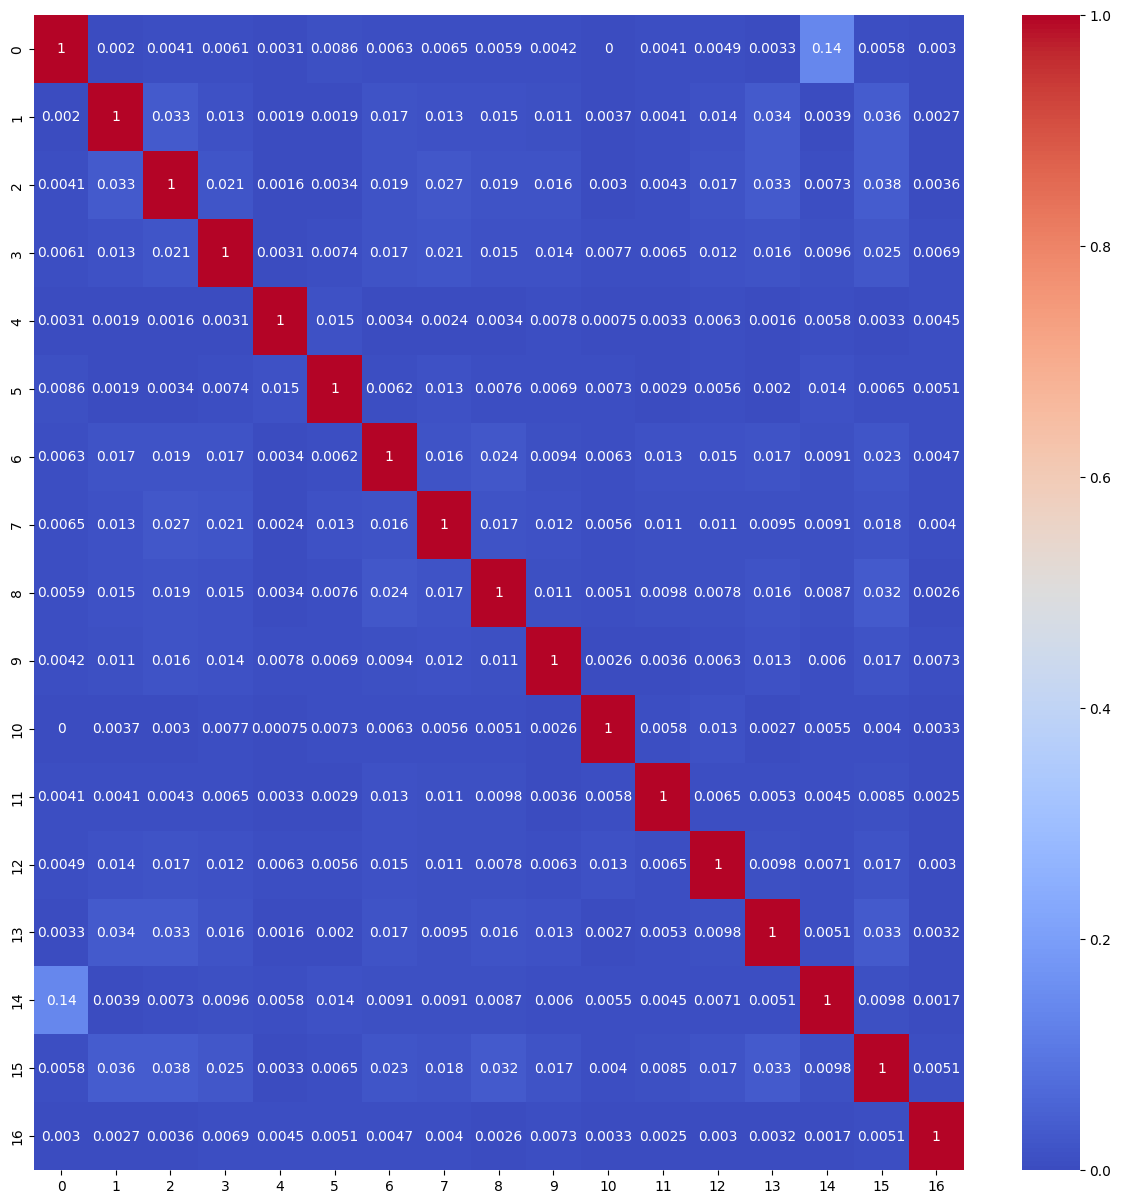

In [12]:
# Heatmap of the Jaccard Similarities
plt.figure(figsize=(15, 15))
sns.heatmap(jaccard_similarities.astype(float), cmap='coolwarm', annot=True)
plt.show()

As we can see from the Heatmap above there are no documents similar. The only pair showing a trace of similarity is doc 14 and doc 0, but still to weak to make a statement. In fact, if we read the documents, we can see that they are not similar at all. Therefore, we can say that could be a false positive (noise).

In [13]:
# Add thresholding s to the jaccard similarities
s = 0.5
for i in range(len(shingles_dict)):
    for j in range(i + 1, len(shingles_dict)):
        if jaccard_similarities[i][j] > s:
            print("Document {} and {} have a Jaccard similarity of {}".format(i, j, jaccard_similarities[i][j]))

No documents exceed the threshold of 0.5, therefore we can say that there are no similar documents.

#### MinHashing

Let us now proceed with the MinHashing class and methods on the real data.

In [14]:
# Get the shingles for each document
shingling = Shingling(k=10)
documents = df["text"]
shingles = [shingling.shingle_document(document) for document in documents] # Get the number of shingles
num_shingles = len(set().union(*shingles))
print("Number of shingles", num_shingles)

Number of shingles 135500


In [15]:
# Find the document with the longest shingle set (lenght of the shingles x documents matrix)
max = 0
for i in range(len(shingles)):
    if len(shingles[i]) > max:
        max = len(shingles[i])

print("The document with the longest shingle set has", max, "shingles")

The document with the longest shingle set has 41537 shingles


In [16]:
p = 1
k = int(max/100*1)
print("The suggested number of hash functions is", k, "-", p, "% of the longest shingle set")

The suggested number of hash functions is 415 - 1 % of the longest shingle set


In [17]:
# Compute the min hashes
k = 500 # We will use 10000 hash functions (close enouh to 415)
print("We will use", k, "hash functions")
min_hashing = MinHashing(k=k, num_shingles=num_shingles) # Take k as 20% of the longest shingle set

min_hashes = []

for shingle in shingles:
    min_hashes.append(min_hashing.minhash(shingle))

We will use 500 hash functions


In [18]:
# Compute Jaccard Similarity with CompareSignatures
jaccard_similarities_min_hashing = pd.DataFrame(columns=[i for i in range(len(shingles_dict))], index=[i for i in range(len(shingles_dict))])

for i in range(len(min_hashes)):
    for j in range(len(min_hashes)):
        jaccard_similarities_min_hashing[i][j] = CompareSignatures.jaccard_similarity(min_hashes[i], min_hashes[j])

jaccard_similarities_min_hashing

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.0,0.038,0.03,0.042,0.024,0.036,0.042,0.038,0.046,0.026,0.018,0.032,0.048,0.034,0.132,0.044,0.038
1,0.038,1.0,0.274,0.134,0.022,0.024,0.146,0.104,0.142,0.162,0.02,0.056,0.124,0.374,0.06,0.288,0.08
2,0.03,0.274,1.0,0.134,0.014,0.026,0.148,0.1,0.128,0.148,0.018,0.052,0.134,0.296,0.058,0.226,0.074
3,0.042,0.134,0.134,1.0,0.018,0.038,0.09,0.062,0.104,0.086,0.016,0.044,0.082,0.124,0.054,0.126,0.074
4,0.024,0.022,0.014,0.018,1.0,0.03,0.018,0.02,0.034,0.016,0.018,0.028,0.022,0.024,0.026,0.018,0.02
5,0.036,0.024,0.026,0.038,0.03,1.0,0.024,0.046,0.032,0.04,0.014,0.022,0.036,0.026,0.042,0.028,0.03
6,0.042,0.146,0.148,0.09,0.018,0.024,1.0,0.076,0.13,0.086,0.028,0.038,0.106,0.132,0.058,0.14,0.066
7,0.038,0.104,0.1,0.062,0.02,0.046,0.076,1.0,0.084,0.102,0.032,0.048,0.076,0.092,0.048,0.094,0.048
8,0.046,0.142,0.128,0.104,0.034,0.032,0.13,0.084,1.0,0.09,0.024,0.04,0.092,0.148,0.058,0.154,0.066
9,0.026,0.162,0.148,0.086,0.016,0.04,0.086,0.102,0.09,1.0,0.028,0.058,0.1,0.132,0.056,0.136,0.06


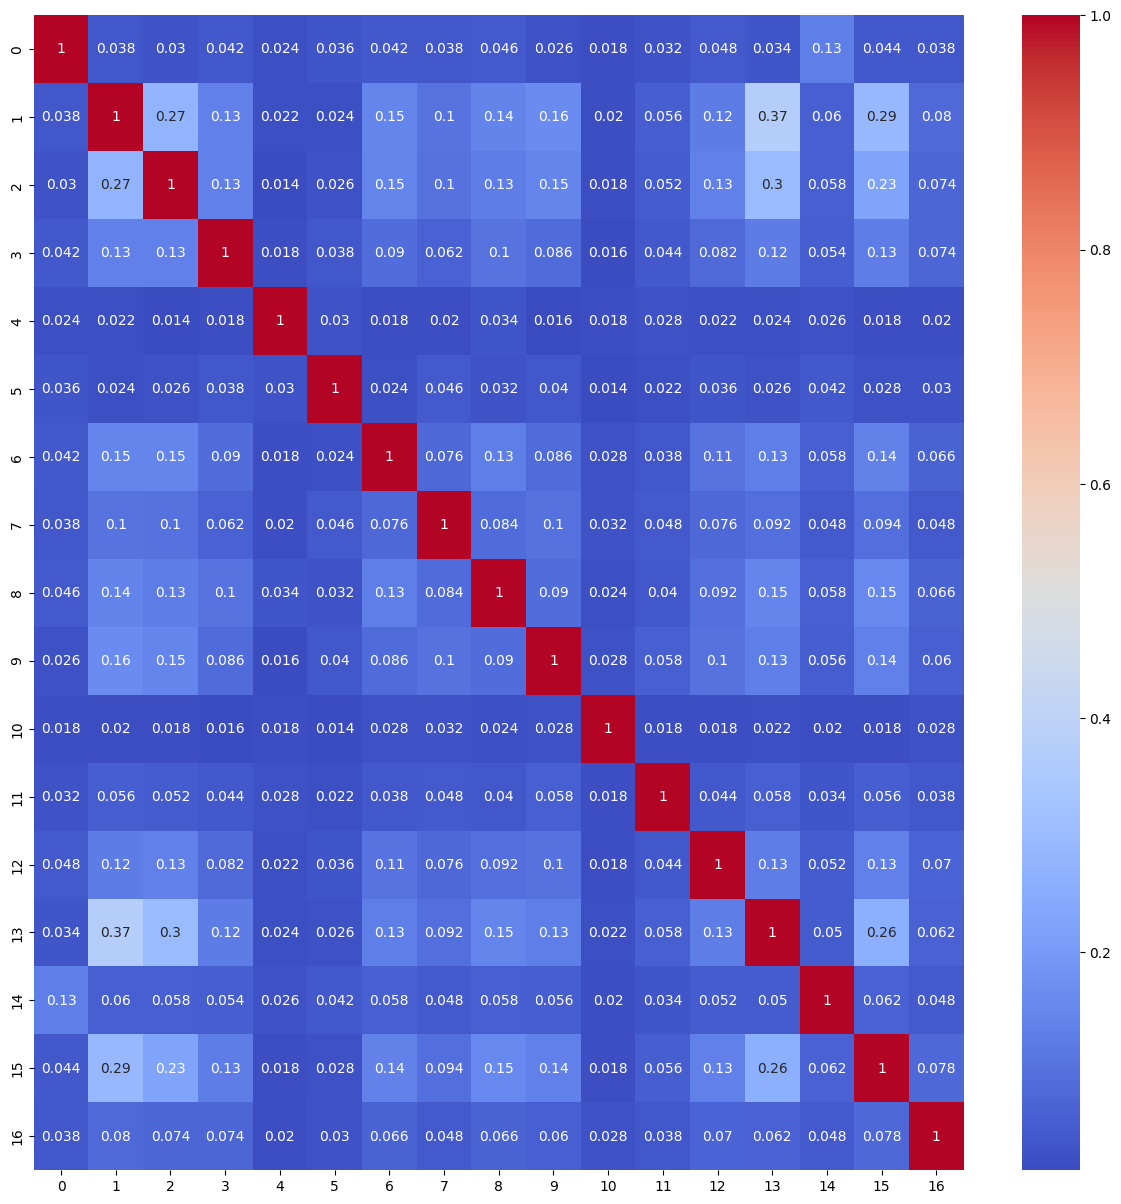

In [19]:
# Heatmap of the Jaccard Similarities with Min Hashing
plt.figure(figsize=(15, 15))
sns.heatmap(jaccard_similarities_min_hashing.astype(float), cmap='coolwarm', annot=True)
plt.show()

As we can see from the Heatmap above, overall the similarities have increased. This is expected, since the MinHashing introduce some error. However, the similarity is preserved, as doc 14 and doc 0 are still similar (0.19 instead of 0.14).

In [20]:
# Add thresholding s to the jaccard similarities
s = 0.5
for i in range(len(shingles_dict)):
    for j in range(i + 1, len(shingles_dict)):
        if jaccard_similarities_min_hashing[i][j] > s:
            print("Document {} and {} have a Jaccard similarity of {}".format(i, j, jaccard_similarities_min_hashing[i][j]))

Again, no documents exceed the threshold of 0.5, therefore we can say that there are no similar documents.

#### LSH

Let us finish by implementing the LSH technique. We should pick b and r to satisfy the equation b*r = k and (1/b)^(1/r) = s.
In our case, we have k=10000, s=0.6 (chosen by us), and we need to calculate b and r.

We end up with the following equation: $$-b*ln(b) = ln(0.6)*k$$, which is a graph equation.
If you plug the equations in tools like https://www.desmos.com/calculator, you can see that the solution is b~62 and r~8.
Now, we have to take different but similar values as b*r=496, which is close to k=10000 but not equal.
Therefore, we can take b=50 and r=10. Now, the first equation is satisfied, and we can proceed with the LSH computation.

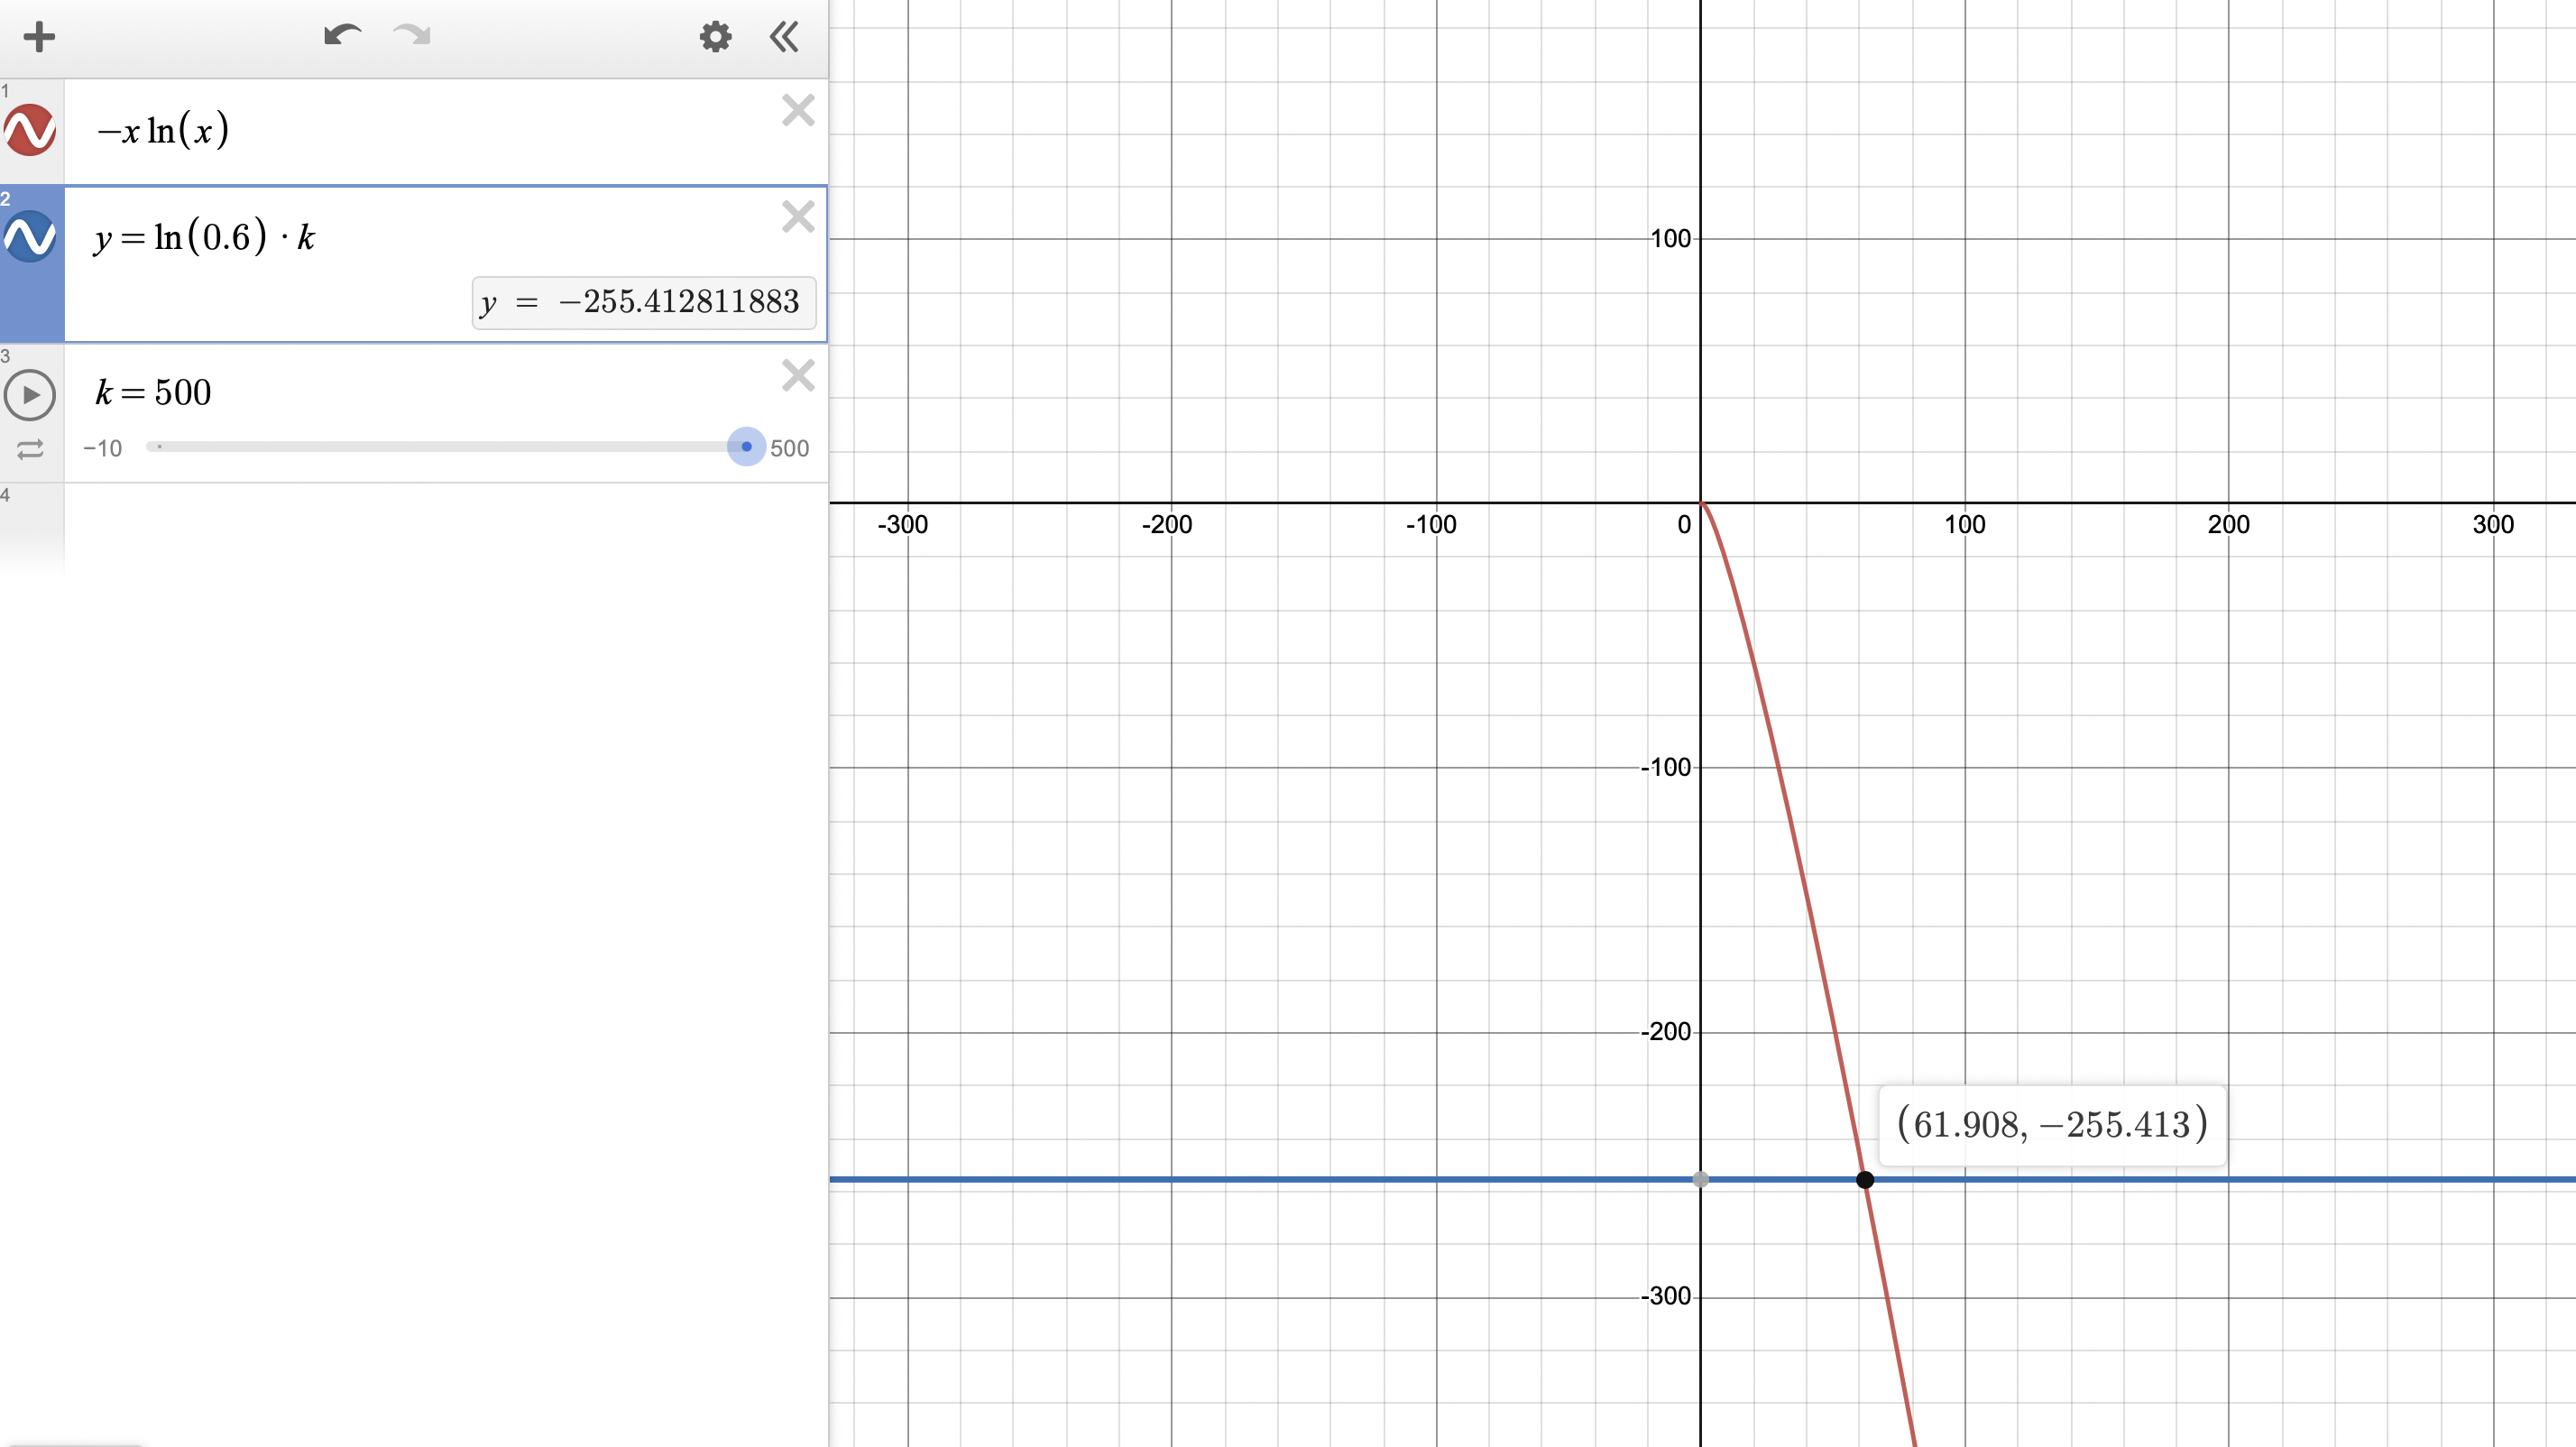

In [21]:
from IPython.display import Image

Image(filename='img/1.png')

In [22]:
b = 50 # Number of bands
r = 10 # Number of rows per band

In [23]:
# Compute LSH
lsh = LSH(b=b, r=r, num_shingles=num_shingles)

lsh_hashes = []

for min_hash in min_hashes:
    lsh_hashes.append(lsh.hash(min_hash))

# Compute Jaccard Similarity with LSH
jaccard_similarities_lsh = pd.DataFrame(columns=[i for i in range(len(shingles_dict))], index=[i for i in range(len(shingles_dict))])

for i in range(len(lsh_hashes)):
    for j in range(len(lsh_hashes)):
        jaccard_similarities_lsh[i][j] = lsh.query(lsh_hashes[i], lsh_hashes[j])

jaccard_similarities_lsh

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.0,0.02,0.04,0.06,0.08,0.06,0.02,0.1,0.02,0.06,0.02,0.06,0.06,0.04,0.08,0.04,0.02
1,0.02,1.0,0.46,0.16,0.04,0.06,0.14,0.2,0.16,0.32,0.02,0.06,0.16,0.54,0.04,0.44,0.14
2,0.04,0.46,1.0,0.12,0.02,0.04,0.14,0.18,0.2,0.28,0.04,0.04,0.12,0.56,0.02,0.32,0.06
3,0.06,0.16,0.12,1.0,0.04,0.04,0.14,0.14,0.2,0.18,0.02,0.06,0.12,0.16,0.06,0.14,0.08
4,0.08,0.04,0.02,0.04,1.0,0.02,0.04,0.02,0.06,0.04,0.02,0.08,0.02,0.02,0.04,0.04,0.0
5,0.06,0.06,0.04,0.04,0.02,1.0,0.04,0.08,0.02,0.06,0.0,0.02,0.04,0.04,0.1,0.06,0.04
6,0.02,0.14,0.14,0.14,0.04,0.04,1.0,0.04,0.16,0.16,0.06,0.04,0.06,0.18,0.02,0.16,0.08
7,0.1,0.2,0.18,0.14,0.02,0.08,0.04,1.0,0.1,0.14,0.04,0.08,0.06,0.2,0.06,0.16,0.06
8,0.02,0.16,0.2,0.2,0.06,0.02,0.16,0.1,1.0,0.08,0.02,0.02,0.1,0.16,0.04,0.14,0.02
9,0.06,0.32,0.28,0.18,0.04,0.06,0.16,0.14,0.08,1.0,0.04,0.1,0.2,0.3,0.02,0.24,0.1


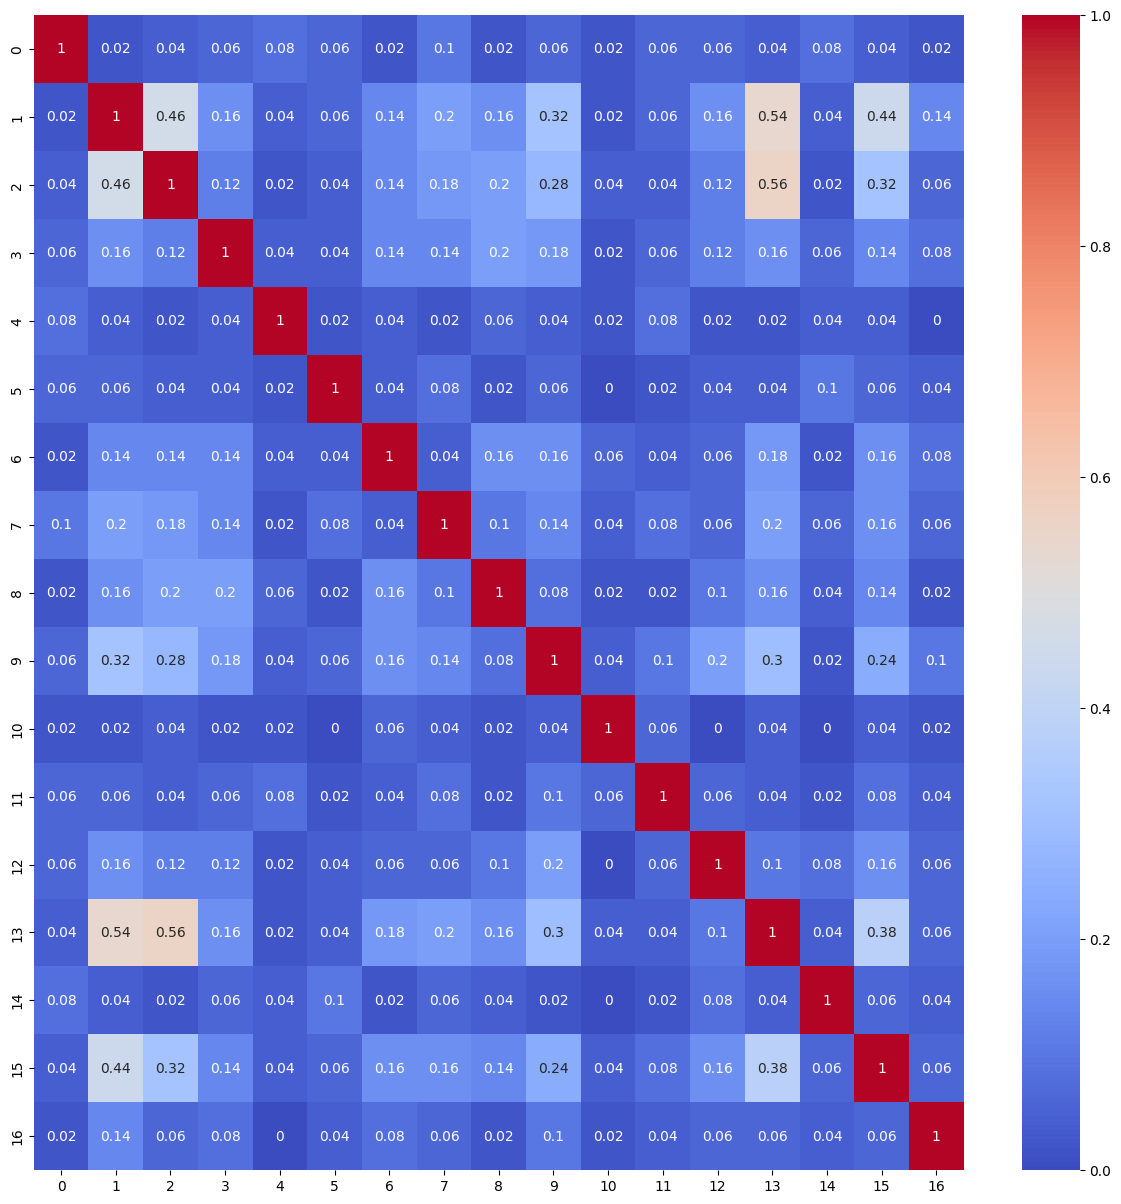

In [24]:
# Heatmap of the Jaccard Similarities with LSH
plt.figure(figsize=(15, 15))
sns.heatmap(jaccard_similarities_lsh.astype(float), cmap='coolwarm', annot=True)
plt.show()

In [25]:
# Add thresholding t to the jaccard similarities
t = 0.4 # Threshold
for i in range(len(shingles_dict)):
    for j in range(i + 1, len(shingles_dict)):
        if jaccard_similarities_lsh[i][j] > t:
            print("Document {} and {} have a Jaccard similarity of {}".format(i, j, jaccard_similarities_lsh[i][j]))

Document 1 and 2 have a Jaccard similarity of 0.46
Document 1 and 13 have a Jaccard similarity of 0.54
Document 1 and 15 have a Jaccard similarity of 0.44
Document 2 and 13 have a Jaccard similarity of 0.56


From the heatmap above, we got see doc 1 - doc 2, doc 1 - doc 13, and doc 2 - doc 13 as similar documents. Manually reading the content of the documents, we did not find any similarity. Therefore, we can say that these are false positives.

We were unsure if the classes and methods were implemented correctly, so we decided to append all the content of doc 5 in doc 14 (in `[data/applications_of_DM copy.csv](https://raw.githubusercontent.com/matteocirca/data-mining-course-kth-2023/main/hw1/data/applications_of_DM%20copy.csv)`).

Before the similarity between the two was 0.02, now it has increased and it is 0.27. Therefore, we can say that the classes and methods are implemented correctly.

## Performance

All of the executions took around 0s, which is expected since the dataset is small and the k values we chose are not too large. But we tried with higher k-s, 1000 for MinHashing, and it took around 3 minutes.
The Notebook was run on a MacBook Pro M1 2021.

## Conclusions

As we can notice from the results above the LSH returns higher values for the similarity. That is because LSH does not concentrate the single values of the signature matrix, but it groups them in buckets. This means that the similarity is not a single value, but it is a range of values. Therefore, two documents could end up in the same bucket even if they do not have all the values in common in that band. This is the reason why the similarity is higher, since then the Jaccard is computed on the number of buckets in common out of the total number of buckets (=number of bands).

Let us show it with and example. Let us consider the following signature matrix (after MinHashing):

In [26]:
d1 = [1, 3, 7, 9]
d2 = [1, 4, 8, 10]

df = pd.DataFrame(columns=['d1', 'd2'])
df['d1'] = d1
df['d2'] = d2
df

,d1,d2
0,1,1
1,3,4
2,7,8
3,9,10


If we compute the Jaccard similarity between the first two columns, using CompareSignatures, we get:
$ \frac{1}{4} = 0.25 $.
If we run LSH with b=2 and r=2, we could get the following new signature matrix:

In [27]:
d1 = [1, 2]
d2 = [1, 3]

df = pd.DataFrame(columns=['d1', 'd2'])
df['d1'] = d1
df['d2'] = d2
df

,d1,d2
0,1,1
1,2,3


And the Jaccard similarity between the first two columns is now:
$ \frac{1}{2} = 0.5 $.
This shows that the similarity is higher, since the two documents are in the same bucket, even if they do not have all the values in common in that band.

We tried to imagine this in a real world scenario, such as classifying images. For example, if we have three images, two of cats (one white and the other one black colored) and one rabbit. If we run the MinHashing, we could end up with the following similarities:
- black cat - white cat: 0.8
- black cat - rabbit: 0.2
- white cat - rabbit: 0.2

While, with LSH we would have:
- black cat - white cat: 1
- black cat - rabbit: 0.5
- white cat - rabbit: 0.5
This is because LSH looks at the feature rather than the single values (pixels). Therefore, it is more robust to noise and it is more accurate.